In [1]:
# Custom Modules
from utils.data_loader import load_crime_dataset
from utils.maps import ChicagoMap

# OS modules
from pathlib import Path

# Dependencies
import pandas as pd
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import matplotlib.pyplot as plt

# VisualConfiguration
sns.set_theme(style="ticks", color_codes=True)

# Misc
import warnings
warnings.filterwarnings('ignore')

# Location of stored dataset
dataset_path = Path('../datasets/chicago-crime-data.csv')

if dataset_path.exists():
    print(f"File found: {dataset_path.name}")
else:
    load_crime_dataset()

# Converting result into dataframe
crime_df = pd.read_csv(dataset_path)

# Importing community names
community_df = pd.read_csv('../assets/maps/comm-areas.csv')

# Convert date column to datetime format
crime_df['date'] = pd.to_datetime(crime_df['date'])

crime_df.rename(columns={'community_area': 'community_number'}, inplace=True)

community_df.rename(columns={'AREA_NUM_1': 'community_number','COMMUNITY': 'community_name'}, inplace=True)

crime_df = crime_df.merge(community_df[['community_name', 'community_number']], on='community_number', how='left')

print(crime_df.shape)
print(crime_df.columns)

crime_df.dropna(inplace=True)

# Filter Numerical columns
num_col = crime_df.select_dtypes(include=['int64','float64']).columns

# Eliminating Outliers using IQR method
# Calculating 25th and 75th percentile
Q1 = crime_df[num_col].quantile(0.25)
Q3 = crime_df[num_col].quantile(0.75)

# Interquartile Range
IQR = Q3 - Q1

# Calculating lower and upper bounds for acceptable data
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

crime_df = crime_df[
    ((crime_df[num_col] >= lower_bound) & (crime_df[num_col] <= upper_bound)).all(axis=1)
]

File found: chicago-crime-data.csv
(1409589, 23)
Index(['id', 'case_number', 'date', 'block', 'iucr', 'primary_type',
       'description', 'location_description', 'arrest', 'domestic', 'beat',
       'district', 'ward', 'community_number', 'fbi_code', 'year',
       'updated_on', 'x_coordinate', 'y_coordinate', 'latitude', 'longitude',
       'location', 'community_name'],
      dtype='object')


In [69]:
crime_df_copy = crime_df.copy()
crime_df_copy.set_index('date',inplace=True)
crime_df_copy.sort_index(inplace=True)

# Filter crimes for September, 2024
sept_crime = crime_df_copy.loc['2024-09']

# Filter crimes for a week in Sept, 2024
week_crime = crime_df_copy.loc['2024-09-01':'2024-09-07']

In [70]:
def dominant_crime_cluster(data, cluster_type = 'kmeans-cluster'):
    crime_type_counts = data.groupby([cluster_type,'primary_type']).size().reset_index(name='count')
    most_common_crimes = crime_type_counts.loc[crime_type_counts.groupby(cluster_type)['count'].idxmax()]
    return most_common_crimes

In [71]:
chicago_map = ChicagoMap()
base_map_fig = chicago_map.plot_ward()

sept_crime_coords = sept_crime[['latitude', 'longitude']].dropna()
week_crime_coords = week_crime[['latitude', 'longitude']].dropna()

## Kmeans Clustering

In [65]:
from sklearn.cluster import KMeans

n_clusters = 5  # Choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
sept_crime_coords['kmeans-cluster'] = kmeans.fit_predict(sept_crime_coords)
week_crime_coords['kmeans-cluster'] = kmeans.fit_predict(week_crime_coords)

# Step 3: Merge cluster labels back into the original data
sept_crime['kmeans-cluster'] = sept_crime_coords['kmeans-cluster']
week_crime['kmeans-cluster'] = week_crime_coords['kmeans-cluster']

In [66]:
fig = px.scatter_mapbox(
    week_crime,
    lat="latitude",
    lon="longitude",
    color="kmeans-cluster",  
    hover_name="primary_type",  
    title="Crime Clusters for a week of September 2024",
    color_discrete_sequence=px.colors.qualitative.Plotly 
)

fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=9.4,
    mapbox_center={"lat": week_crime_coords['latitude'].mean(), "lon": week_crime_coords['longitude'].mean()},
    height=700,
    coloraxis_showscale=False 
)

print(dominant_crime_cluster(week_crime))
fig.update_traces(marker=dict(size=4)) 
fig.show()

    kmeans-cluster primary_type  count
2                0      BATTERY    188
41               1        THEFT    607
45               2      BATTERY    136
65               3      BATTERY    234
87               4      BATTERY    190


In [67]:
fig = px.scatter_mapbox(
    sept_crime,
    lat="latitude",
    lon="longitude",
    color="kmeans-cluster",  # Color by cluster
    hover_name="primary_type",  # Optional: Replace with a relevant column for tooltips
    title="Crime Clusters for September 2024",
    color_discrete_sequence=px.colors.qualitative.Plotly  # Use discrete colors
)

# Customize the map style and layout
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=9.4,
    mapbox_center={"lat": sept_crime_coords['latitude'].mean(), "lon": sept_crime_coords['longitude'].mean()},
    height=700,
    coloraxis_showscale=False  # Disable the color scale legend
)

print(dominant_crime_cluster(sept_crime))

fig.update_traces(marker=dict(size=4))  # Customize marker size
fig.show()


     kmeans-cluster primary_type  count
2                 0      BATTERY    885
50                1        THEFT   1373
75                2        THEFT   2019
79                3      BATTERY    469
105               4      BATTERY    761


## DBScan Clsutering

In [73]:
from sklearn.cluster import DBSCAN

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.01, min_samples=5)  # Adjust eps and min_samples for your data

sept_crime_coords['dbscan-cluster'] = dbscan.fit_predict(sept_crime_coords)
week_crime_coords['dbscan-cluster'] = dbscan.fit_predict(week_crime_coords)

sept_crime['dbscan-cluster'] = sept_crime_coords['dbscan-cluster']
week_crime['dbscan-cluster'] = week_crime_coords['dbscan-cluster']

In [74]:
fig = px.scatter_mapbox(
    week_crime,
    lat="latitude",
    lon="longitude",
    color="dbscan-cluster",  
    hover_name="primary_type",  
    title="Crime Clusters for a week of September 2024",
    color_discrete_sequence=px.colors.qualitative.Plotly 
)

fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=9.4,
    mapbox_center={"lat": week_crime_coords['latitude'].mean(), "lon": week_crime_coords['longitude'].mean()},
    height=700,
    coloraxis_showscale=False 
)

print(dominant_crime_cluster(week_crime, cluster_type='dbscan-cluster'))
fig.update_traces(marker=dict(size=4)) 
fig.show()

    dbscan-cluster        primary_type  count
2               -1  DECEPTIVE PRACTICE      4
32               0               THEFT   1282
42               1               THEFT      5
44               2       OTHER OFFENSE      2
54               3               THEFT      9
57               4               THEFT      3
59               5             BATTERY      4
64               6             ASSAULT      1


In [75]:
fig = px.scatter_mapbox(
    sept_crime,
    lat="latitude",
    lon="longitude",
    color="dbscan-cluster",  
    hover_name="primary_type",  
    title="Crime Clusters for September 2024",
    color_discrete_sequence=px.colors.qualitative.Plotly 
)

fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=9.4,
    mapbox_center={"lat": sept_crime_coords['latitude'].mean(), "lon": sept_crime_coords['longitude'].mean()},
    height=700,
    coloraxis_showscale=False 
)

print(dominant_crime_cluster(sept_crime, cluster_type='dbscan-cluster'))
fig.update_traces(marker=dict(size=4)) 
fig.show()

    dbscan-cluster primary_type  count
0               -1      BATTERY      2
32               0        THEFT   5264
45               1        THEFT     11


## Agglomerative Clustering

In [76]:
from sklearn.cluster import AgglomerativeClustering

# Perform Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=5, linkage='ward')  # Adjust n_clusters

sept_crime_coords['agglomerative-cluster'] = agglomerative.fit_predict(sept_crime_coords)
week_crime_coords['agglomerative-cluster'] = agglomerative.fit_predict(week_crime_coords)

sept_crime['agglomerative-cluster'] = sept_crime_coords['agglomerative-cluster']
week_crime['agglomerative-cluster'] = week_crime_coords['agglomerative-cluster']

In [77]:
fig = px.scatter_mapbox(
    sept_crime,
    lat="latitude",
    lon="longitude",
    color="agglomerative-cluster",  
    hover_name="primary_type",  
    title="Crime Clusters for September 2024",
    color_discrete_sequence=px.colors.qualitative.Plotly 
)

fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=9.4,
    mapbox_center={"lat": sept_crime_coords['latitude'].mean(), "lon": sept_crime_coords['longitude'].mean()},
    height=700,
    coloraxis_showscale=False 
)

print(dominant_crime_cluster(sept_crime, cluster_type='agglomerative-cluster'))
fig.update_traces(marker=dict(size=4)) 
fig.show()

    agglomerative-cluster primary_type  count
24                      0        THEFT   2468
28                      1      BATTERY    947
63                      2        THEFT     11
66                      3      BATTERY    734
90                      4      BATTERY   1422


In [79]:
fig = px.scatter_mapbox(
    week_crime,
    lat="latitude",
    lon="longitude",
    color="agglomerative-cluster",  
    hover_name="primary_type",  
    title="Crime Clusters for September 2024",
    color_discrete_sequence=px.colors.qualitative.Plotly 
)

fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=9.4,
    mapbox_center={"lat": week_crime_coords['latitude'].mean(), "lon": week_crime_coords['longitude'].mean()},
    height=700,
    coloraxis_showscale=False 
)

print(dominant_crime_cluster(week_crime, cluster_type='agglomerative-cluster'))
fig.update_traces(marker=dict(size=4)) 
fig.show()

    agglomerative-cluster primary_type  count
23                      0        THEFT    887
32                      1        THEFT      5
41                      2        THEFT      9
51                      3        THEFT      7
54                      4      BATTERY    417


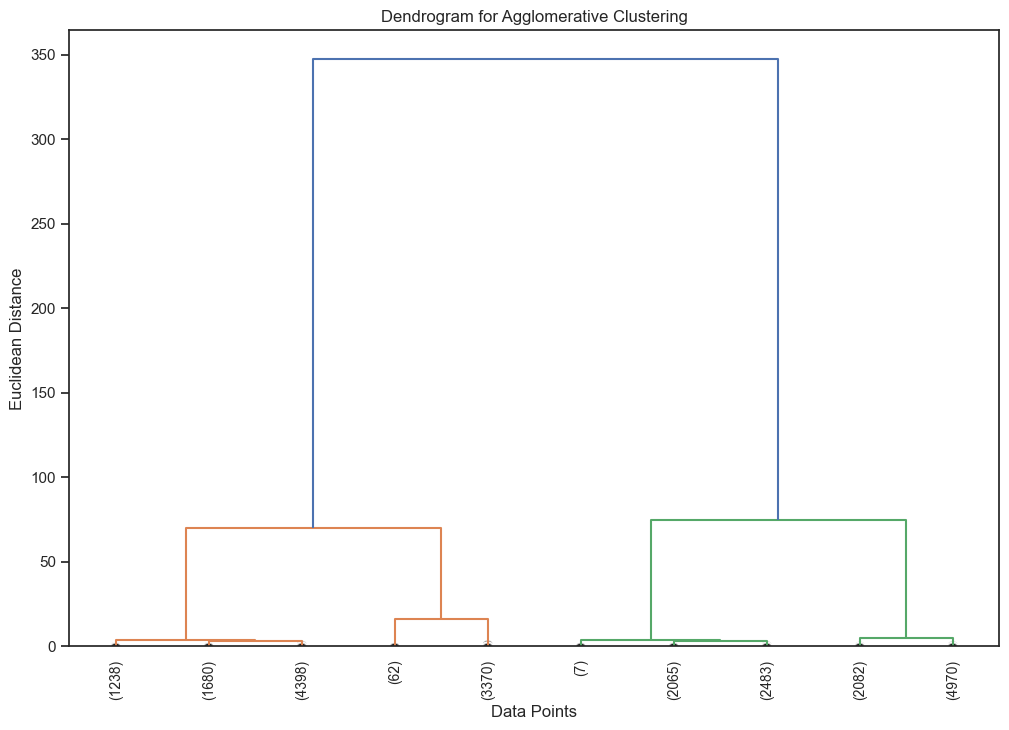

In [80]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering and compute linkage matrix
linkage_matrix = linkage(sept_crime_coords, method='ward')  # 'ward' minimizes variance within clusters

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # Limit the depth of the dendrogram
    p=10,                   # Show the top 10 merged clusters
    leaf_rotation=90.,      # Rotate leaf labels for better readability
    leaf_font_size=10.,     # Adjust font size for leaf labels
    show_contracted=True    # Show summary nodes for truncated branches
)
plt.title("Dendrogram for Agglomerative Clustering")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()